# Water Potability Data Exploration Notebook

In [1]:
import sys
sys.path.append('/home/jovyan/work')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession, DataFrame

%matplotlib inline

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

21/07/27 18:33:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Load the Dataset

In [3]:
df = spark.read.csv('../data/water_potability.csv',inferSchema=True, header=True)

In [4]:
record_count = df.count()
print('Total record count: {}'.format(record_count))

Total record count: 3276


In [5]:
# Show a Sample
df.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             null| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              null| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              n

## Exploratory Data Analysis

In [6]:
# Show the Schema and Check Types
df.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [7]:
# Convert to Pandas and View Summary Statistics
df_pandas = df.toPandas()
df_pandas.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


### Explore Missing Values

In [8]:
# Check for Missing Data
null_counts = df_pandas.isnull().sum()
null_counts

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [9]:
print('ph null percentage: {}'.format(null_counts['ph']/record_count*100))
print('Sulfate null percentage: {}'.format(null_counts['Sulfate']/record_count*100))
print('Trihalomethanes null percentage: {}'.format(null_counts['Trihalomethanes']/record_count*100))

ph null percentage: 14.987789987789988
Sulfate null percentage: 23.84004884004884
Trihalomethanes null percentage: 4.945054945054945


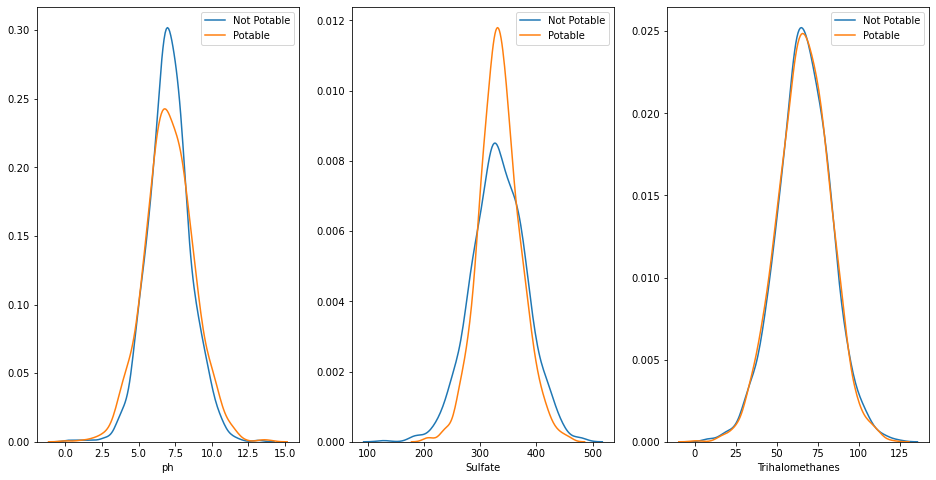

In [10]:
df_nulls = df_pandas[['ph', 'Sulfate', 'Trihalomethanes']]
potable = df_pandas.query('Potability == 0')
not_potable = df_pandas.query('Potability == 1')

fig = plt.figure(figsize=(16,8))
num_cols = 3

for ax,column in enumerate(df_nulls.columns[:df_nulls.shape[1]]):
    plt.subplot(1, num_cols, ax+1)
    sns.kdeplot(x=not_potable[column],label='Not Potable')
    sns.kdeplot(x=potable[column],label='Potable')
    plt.legend(prop=dict(size=df_pandas.shape[1]))
    plt.ylabel('')

For trihalomethane levels, they are roughly the same for potable and nonpotable water. We shoould be able to impute the missing data with the mean, and it should not change our model prediction much.

However the ph level is lower in potable water, and the sulfate level is higher in potable water. So, we need to think about what to do with those values.

In [11]:
df_pandas.corr().abs()['ph'].sort_values(ascending = False)

ph                 1.000000
Solids             0.089288
Hardness           0.082096
Organic_carbon     0.043503
Turbidity          0.039057
Chloramines        0.034350
Conductivity       0.018614
Sulfate            0.018203
Potability         0.003556
Trihalomethanes    0.003354
Name: ph, dtype: float64

In [12]:
df_pandas.corr().abs()['Sulfate'].sort_values(ascending = False)

Sulfate            1.000000
Solids             0.171804
Hardness           0.106923
Organic_carbon     0.030831
Trihalomethanes    0.030274
Chloramines        0.027244
Potability         0.023577
ph                 0.018203
Conductivity       0.016121
Turbidity          0.011187
Name: Sulfate, dtype: float64

Unfortunately, there are any strong correlations with either feature that we can use to impute the value with stratification.

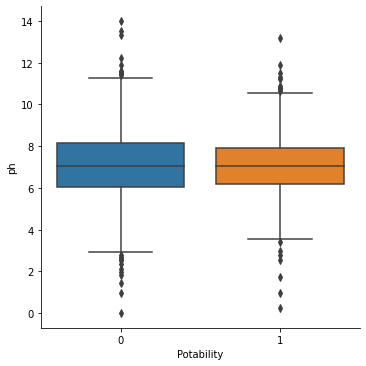

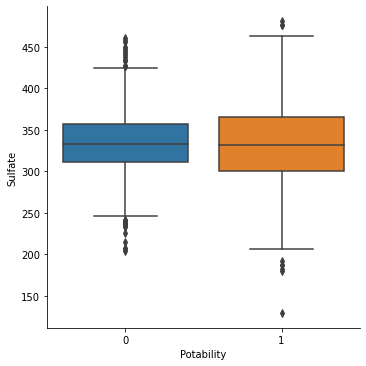

In [13]:
sns.catplot(data=df_pandas, x='Potability', y='ph', kind='box');
sns.catplot(data=df_pandas, x='Potability', y='Sulfate', kind='box');

The mean value does appear to be roughtly the same for potable and non-potable water.

### Target Distribution

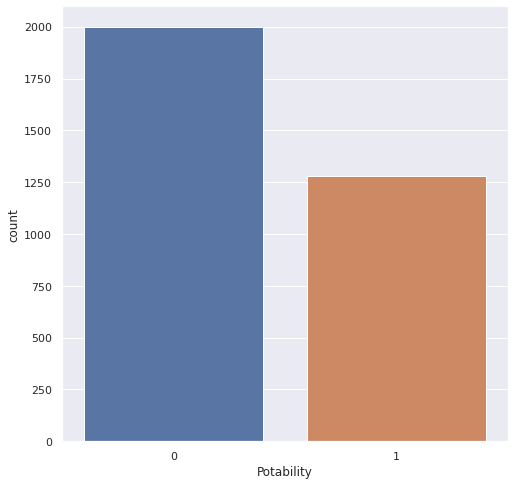

In [14]:
# Distribution of Target Column
sns.set(rc={"figure.figsize":(8, 8)})
sns.countplot(x=df_pandas['Potability']);

This is an unbalanced dataset, so when we build out our pipeline, we will want to undersample the majority class to balance things out. I will create and test out a function to do that in the next notebook.

### Correlations

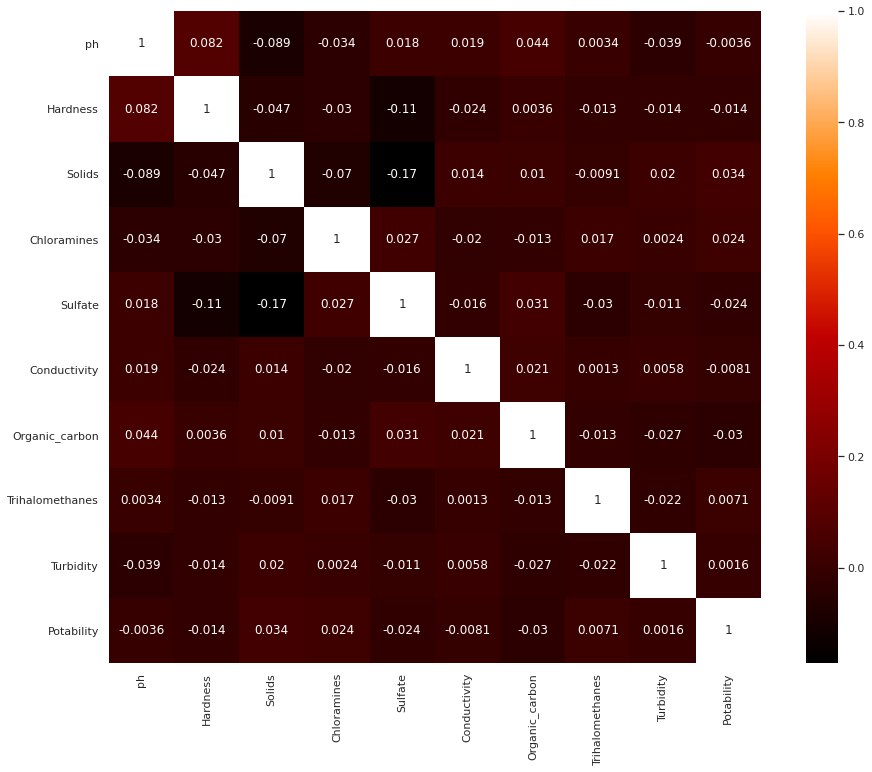

In [15]:
corrs = df_pandas.corr()
sns.set(rc={"figure.figsize":(16, 12)})
sns.heatmap(corrs, square=True, annot=True, cbar=True, cmap="gist_heat");

The correlation matrix shows very weak correlation among the features. This suggests they are somewhat independent of each other. There doesn't seem to be any multicollinearity, and most feature are negatively correlated with potability.